In [1]:
#import data by kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d shashankrapolu/human-action-recognition-dataset

 99% 206M/208M [00:07<00:00, 34.7MB/s]
100% 208M/208M [00:07<00:00, 27.8MB/s]


In [3]:
#file unzip
import zipfile
zip_ref = zipfile.ZipFile('/content/human-action-recognition-dataset.zip')
zip_ref.extractall('/content/Data1')
zip_ref.close()

In [4]:
!gdown  https://drive.google.com/uc?id=1YfVZ7aUefO8Zx5UVnyJg8nIuOLyNcx-Y

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1YfVZ7aUefO8Zx5UVnyJg8nIuOLyNcx-Y 



In [5]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.0 MB/s eta 0:00:00


In [6]:
# Pytorch
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Build up the pretrained transformers model
from transformers import ViTFeatureExtractor, ViTModel

# Plot tool
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

In [7]:
# Set up device and training hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256
latent_dim = 256
epochs = 1
learning_rate = 5e-4

print(device)

cuda


# Build up dataset and dataloader

In [8]:
# Add the transformation of image
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

# Path for training and validation dataset
training_path = "/content/Data1/Structured/train"
validating_path = "/content/Data1/Structured/test"

# **Data Preprocssing**

In [9]:
# Create train, val dataset
training_dataset = ImageFolder(training_path,
                               transform=data_transforms)
validating_dataset = ImageFolder(validating_path,
                                 transform=data_transforms)

# Create train, val dataloader
training_dataloader = DataLoader(training_dataset,
                                 batch_size=batch_size,
                                 shuffle=True)
val_dataloader = DataLoader(validating_dataset,
                            batch_size=batch_size,
                            shuffle=True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


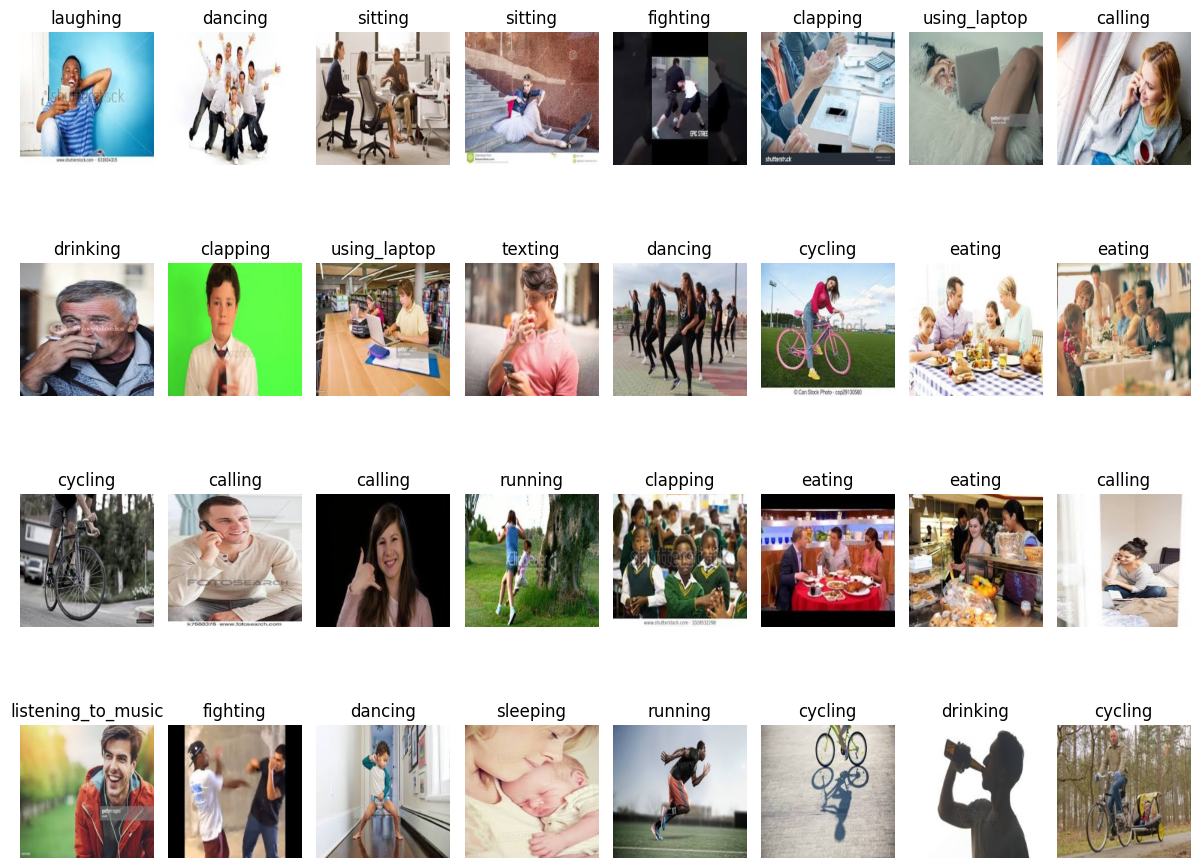

In [10]:
image_size = 32

# Get the image from dataloader
show_images, show_labels = next(iter(training_dataloader))
show_images = show_images[:image_size]
show_labels = show_labels[:image_size]

ncols = 8
nrows = int(image_size / ncols) + 1

# Set up the figure size
plt.figure(figsize=(12, 12))


def inverse_normalized(image):
    # Clamp the value to (0.0, 1.0) for floats
    image = torch.clamp(input=image * 0.5 + 0.5,
                        min=0.0,
                        max=1.0)
    return image


for idx in range(len(show_images)):
    # Set up the subplot
    plt.subplot(nrows, ncols, idx + 1)

    # Close the axis and plot the image
    plt.axis("off")
    # Note that the label is change into integer, we should change it back to category
    plt.title(training_dataset.classes[show_labels[idx].item()])
    # Note that the image channel of tensor is: (channel, width, height)
    # We need to change it to (width, height, channel) which we use permute to realize it
    plt.imshow(inverse_normalized(show_images[idx].permute(1, 2, 0)))

# Avoid overlapping of different titles
plt.tight_layout()

# **Build the model**

In [11]:
class CategoryClass(nn.Module):
    def __init__(self, vit, latent_dim, classes_):
        super(CategoryClass, self).__init__()

        self.classes_ = classes_

        # Set up model architecture
        self.vit = vit
        self.fc_1 = nn.Linear(768, latent_dim)
        self.fc_out = nn.Linear(latent_dim, self.classes_)
        self.dropout = nn.Dropout(0.2)

    def forward(self, in_data):
        # Type of output `BaseModelOutputWithPooling`
        vit_outputs = self.vit(in_data)

        # Shape of pooler_output: (batch_size, hidden_size)
        pooler_output = vit_outputs.pooler_output

        # Pass through the linear layout to predict the class
        # Shape of output: (batch_size, classes_)
        outputs = torch.relu(self.fc_1(pooler_output))
        outputs = self.fc_out(self.dropout(outputs))

        return outputs

In [12]:
# Set up the pretrained model
vit = ViTModel.from_pretrained('google/vit-base-patch16-224')

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Freeze the layers in vit exclude the pooler layers
for param in vit.parameters():
    param.requires_grad = False

vit.pooler.dense.weight.requires_grad = True
vit.pooler.dense.bias.requires_grad = True

In [14]:
# Create the complete model
model = CategoryClass(vit,
                      latent_dim,
                      len(training_dataset.classes)).to(device)

In [15]:
# Set up loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), learning_rate)

In [16]:
# Save the training and validating information
training_loss_history =[]
training_accuracy_history = []
validating_loss_history = []
validating_accuracy_history = []

# We only train one epoch
#  Therefore, we save the batch information
batch_loss_history = []
batch_accuracy_history = []

for epoch in range(epochs):
    # Set to the train mode
    model.train()

    train_epoch_loss = 0.0
    train_epoch_accuracy = 0.0
    for idx, (images, labels) in enumerate(training_dataloader):
        # Move the data to the device
        images = images.to(device)
        labels = labels.to(device)

        # Pass through the model
        outputs = model(images)

        # Count the loss and update the parameters
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the training information
        train_epoch_loss += loss.item()
        predict_class = outputs.argmax(dim=-1)
        accuracy = torch.sum(predict_class == labels).item() / labels.shape[0]
        train_epoch_accuracy += accuracy

        # Save the batch information
        batch_loss_history.append(loss.item())
        batch_accuracy_history.append(accuracy)

        # Print batch information
        print(f"Batch {idx + 1} in epoch {epoch + 1}/{epochs}")
        print(f"Average loss: {loss.item()}")
        print(f"Average accuracy {accuracy}")

    # Set to the eval mode
    model.eval()

    val_epoch_loss = 0.0
    val_epoch_accuracy = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            # Move data to the device
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            # Pass through model
            val_outputs = model(val_images)

            # Count the loss and accuracy
            val_epoch_loss += criterion(val_outputs, val_labels)
            val_predict_class = val_outputs.argmax(dim=-1)
            val_epoch_accuracy += torch.sum(val_predict_class == val_labels).item() / val_labels.shape[0]

    # Save the epoch information
    training_loss_history.append(train_epoch_loss / len(training_dataloader))
    training_accuracy_history.append(train_epoch_accuracy / len(training_dataloader))
    validating_loss_history.append(val_epoch_loss / len(val_dataloader))
    validating_accuracy_history.append(val_epoch_accuracy / len(val_dataloader))

    # Print the information
    print(f"Epoch {epoch + 1}")
    print(f"Average training loss: {training_loss_history[-1]}, Average validation loss: {validating_loss_history[-1]}")
    print(f"Average training accuracy: {training_accuracy_history[-1]}, Average validation accuracy: {validating_accuracy_history[-1]}")

Batch 1 in epoch 1/1
Average loss: 2.711282968521118
Average accuracy 0.07421875
Batch 2 in epoch 1/1
Average loss: 2.5946266651153564
Average accuracy 0.30078125
Batch 3 in epoch 1/1
Average loss: 2.4566173553466797
Average accuracy 0.51171875
Batch 4 in epoch 1/1
Average loss: 2.309718370437622
Average accuracy 0.625
Batch 5 in epoch 1/1
Average loss: 2.1869664192199707
Average accuracy 0.6171875
Batch 6 in epoch 1/1
Average loss: 1.9842501878738403
Average accuracy 0.703125
Batch 7 in epoch 1/1
Average loss: 1.86953604221344
Average accuracy 0.6796875
Batch 8 in epoch 1/1
Average loss: 1.6902480125427246
Average accuracy 0.71484375
Batch 9 in epoch 1/1
Average loss: 1.585963249206543
Average accuracy 0.6953125
Batch 10 in epoch 1/1
Average loss: 1.4412815570831299
Average accuracy 0.703125
Batch 11 in epoch 1/1
Average loss: 1.3251073360443115
Average accuracy 0.73046875
Batch 12 in epoch 1/1
Average loss: 1.263578176498413
Average accuracy 0.70703125
Batch 13 in epoch 1/1
Average l

# Inception Model

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from keras.layers import Dropout, Dense, Flatten, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Conv2D, MaxPool2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception

import cv2

from tqdm import tqdm
import os
import gc

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings("ignore")

In [25]:
images = []
labels = []

main_directory = '/content/Data1/Structured/train'

for animal in tqdm(os.listdir(main_directory)):
    for i in range(len(os.listdir(main_directory + '/' + animal))):
        if i < 30:
            img = cv2.imread(main_directory + '/' + animal + '/' + os.listdir(main_directory + '/' + animal)[i])
            resized_img = cv2.resize(img,(224,224))
            resized_img = resized_img / 255.0
            images.append(resized_img)
            labels.append(animal)

images = np.array(images,dtype = 'float32')

100%|██████████| 15/15 [00:00<00:00, 15.03it/s]


In [26]:
le = preprocessing.LabelEncoder()
le.fit(labels)
class_names = le.classes_
labels = le.transform(labels)

labels = np.array(labels, dtype = 'uint8')
labels = np.resize(labels, (len(labels),1))

In [27]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.33, stratify = labels)

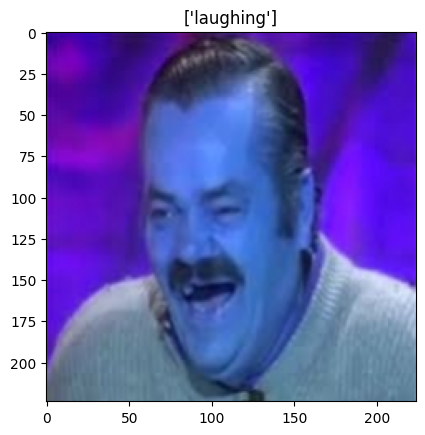

In [28]:
n = np.random.randint(0,np.shape(train_images)[0])

plt.imshow(train_images[n])
plt.title(str(le.inverse_transform([train_labels[n]])))
plt.show()

# Inception Model

In [31]:
inception_model = Sequential()

inception_base_model = InceptionV3(include_top = False, input_shape = (224,224,3))

inception_model.add(inception_base_model)

inception_model.add(GlobalAveragePooling2D())

inception_model.add(Dense(units = 15, activation = 'softmax'))

inception_model.summary()

early_stopping = EarlyStopping( monitor = 'val_accuracy', mode = 'max', min_delta = 1,patience = 20,restore_best_weights = True,verbose = 0)

# Compile
inception_model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 0.0001) , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

# Train
inception = inception_model.fit(train_images, train_labels, batch_size = 32, epochs = 5, callbacks = [early_stopping], validation_split = 0.2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 15)                30735     
                                                                 
Total params: 21,833,519
Trainable params: 21,799,087
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/5
8/8 [==============================] - 35s 497ms/step - loss: 2.6130 - accuracy: 0.1583 - val_loss: 2.7183 - val_accuracy: 0.1803
Epoch 2/5
8/8 [==============================] - 2s 237ms/step - loss: 0.8500 - accuracy: 0.954

In [32]:
inception_predictions = inception_model.predict(test_images)
inception_predictions = np.argmax(inception_predictions,axis = 1)

5/5 [==============================] - 2s 88ms/step


# Xception Model

In [33]:
xception_model = Sequential()

xception_base_model = Xception(include_top = False, input_shape = (224,224,3))

xception_model.add(xception_base_model)

xception_model.add(GlobalAveragePooling2D())

xception_model.add(Dense(units = 15, activation = 'softmax'))

xception_model.summary()

early_stopping = EarlyStopping( monitor = 'val_accuracy', mode = 'max', min_delta = 1,patience = 20,restore_best_weights = True,verbose = 0)

# Compile
xception_model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 0.0001) , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

# Train
xception = xception_model.fit(train_images, train_labels, batch_size = 32, epochs = 5, callbacks = [early_stopping], validation_split = 0.2)

83683744/83683744 [==============================] - 3s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 15)                30735     
                                                                 
Total params: 20,892,215
Trainable params: 20,837,687
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/5
8/8 [==============================] - 41s 1s/step - loss: 2.6399 - accuracy: 0.1583 - val_loss: 2.5031 - val_accuracy: 0.1967
Epoch 2/5
8/8 [==================

# AlexNet Model

In [34]:
alex_model = Sequential()

alex_model.add(Conv2D(filters = 96, kernel_size = (11,11), strides = (4,4), activation = 'relu', input_shape = (224,224,3)))
alex_model.add(BatchNormalization())
alex_model.add(MaxPool2D(pool_size = (3,3), strides = (2,2)))

alex_model.add(Conv2D(filters = 256, kernel_size = (5,5), strides = (1,1), activation = 'relu', padding = 'same'))
alex_model.add(BatchNormalization())
alex_model.add(MaxPool2D(pool_size = (3,3), strides = (2,2)))

alex_model.add(Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), activation = 'relu', padding = 'same'))
alex_model.add(BatchNormalization())

alex_model.add(Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), activation = 'relu', padding = 'same'))
alex_model.add(BatchNormalization())

alex_model.add(Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), activation = 'relu', padding = 'same'))
alex_model.add(BatchNormalization())
alex_model.add(MaxPool2D(pool_size = (3,3), strides = (2,2)))

alex_model.add(Flatten())

alex_model.add(Dense(units = 4096, activation = 'relu'))
alex_model.add(Dropout(0.5))

alex_model.add(Dense(units = 4096, activation = 'relu'))
alex_model.add(Dropout(0.5))

alex_model.add(Dense(units = 15, activation = 'softmax'))

early_stopping = EarlyStopping( monitor = 'val_accuracy', mode = 'max', min_delta = 1,patience = 20,restore_best_weights = True,verbose = 0)

# Compile
alex_model.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

alex_model.summary()

# Train
alex = alex_model.fit(train_images, train_labels, batch_size = 32, epochs = 5, callbacks = [early_stopping], validation_split = 0.2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_380 (Conv2D)         (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization_380 (Ba  (None, 54, 54, 96)       384       
 tchNormalization)                                               
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 26, 26, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_381 (Conv2D)         (None, 26, 26, 256)       614656    
                                                                 
 batch_normalization_381 (Ba  (None, 26, 26, 256)      1024      
 tchNormalization)                                               
                                                      

In [35]:
alex_predictions = alex_model.predict(test_images)
alex_predictions = np.argmax(alex_predictions,axis = 1)

5/5 [==============================] - 1s 95ms/step


# VGG16

In [36]:
vgg_model = Sequential()

vgg_base_model = VGG16(include_top = False, weights="imagenet", input_shape = (224,224,3))
print(f'Number of layers in VGG16 : {len(vgg_base_model.layers)}')

vgg_base_model.trainable = True

for layer in vgg_base_model.layers[:10]:
    layer.trainable = False

vgg_model.add(vgg_base_model)

vgg_model.add(GlobalAveragePooling2D())

vgg_model.add(Dense(units = 15, activation = 'softmax'))

vgg_model.summary()

early_stopping = EarlyStopping( monitor = 'val_accuracy', mode = 'max', min_delta = 1,patience = 20,restore_best_weights = True,verbose = 0)

# Compile
vgg_model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001) , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

# Train
vgg = vgg_model.fit(train_images, train_labels, batch_size = 32, epochs = 5, callbacks = [early_stopping], validation_split = 0.2)

58889256/58889256 [==============================] - 2s 0us/step
Number of layers in VGG16 : 19
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 15)                7695      
                                                                 
Total params: 14,722,383
Trainable params: 12,986,895
Non-trainable params: 1,735,488
_________________________________________________________________
Epoch 1/5
8/8 [==============================] - 18s 1s/step - loss: 2.8042 - accuracy: 0.0708 - val_loss: 2.6019 - val_accuracy: 0.2459

In [37]:
vgg_predictions = vgg_model.predict(test_images)
vgg_predictions = np.argmax(vgg_predictions,axis = 1)

5/5 [==============================] - 4s 872ms/step


# Training & Validation Accuracy

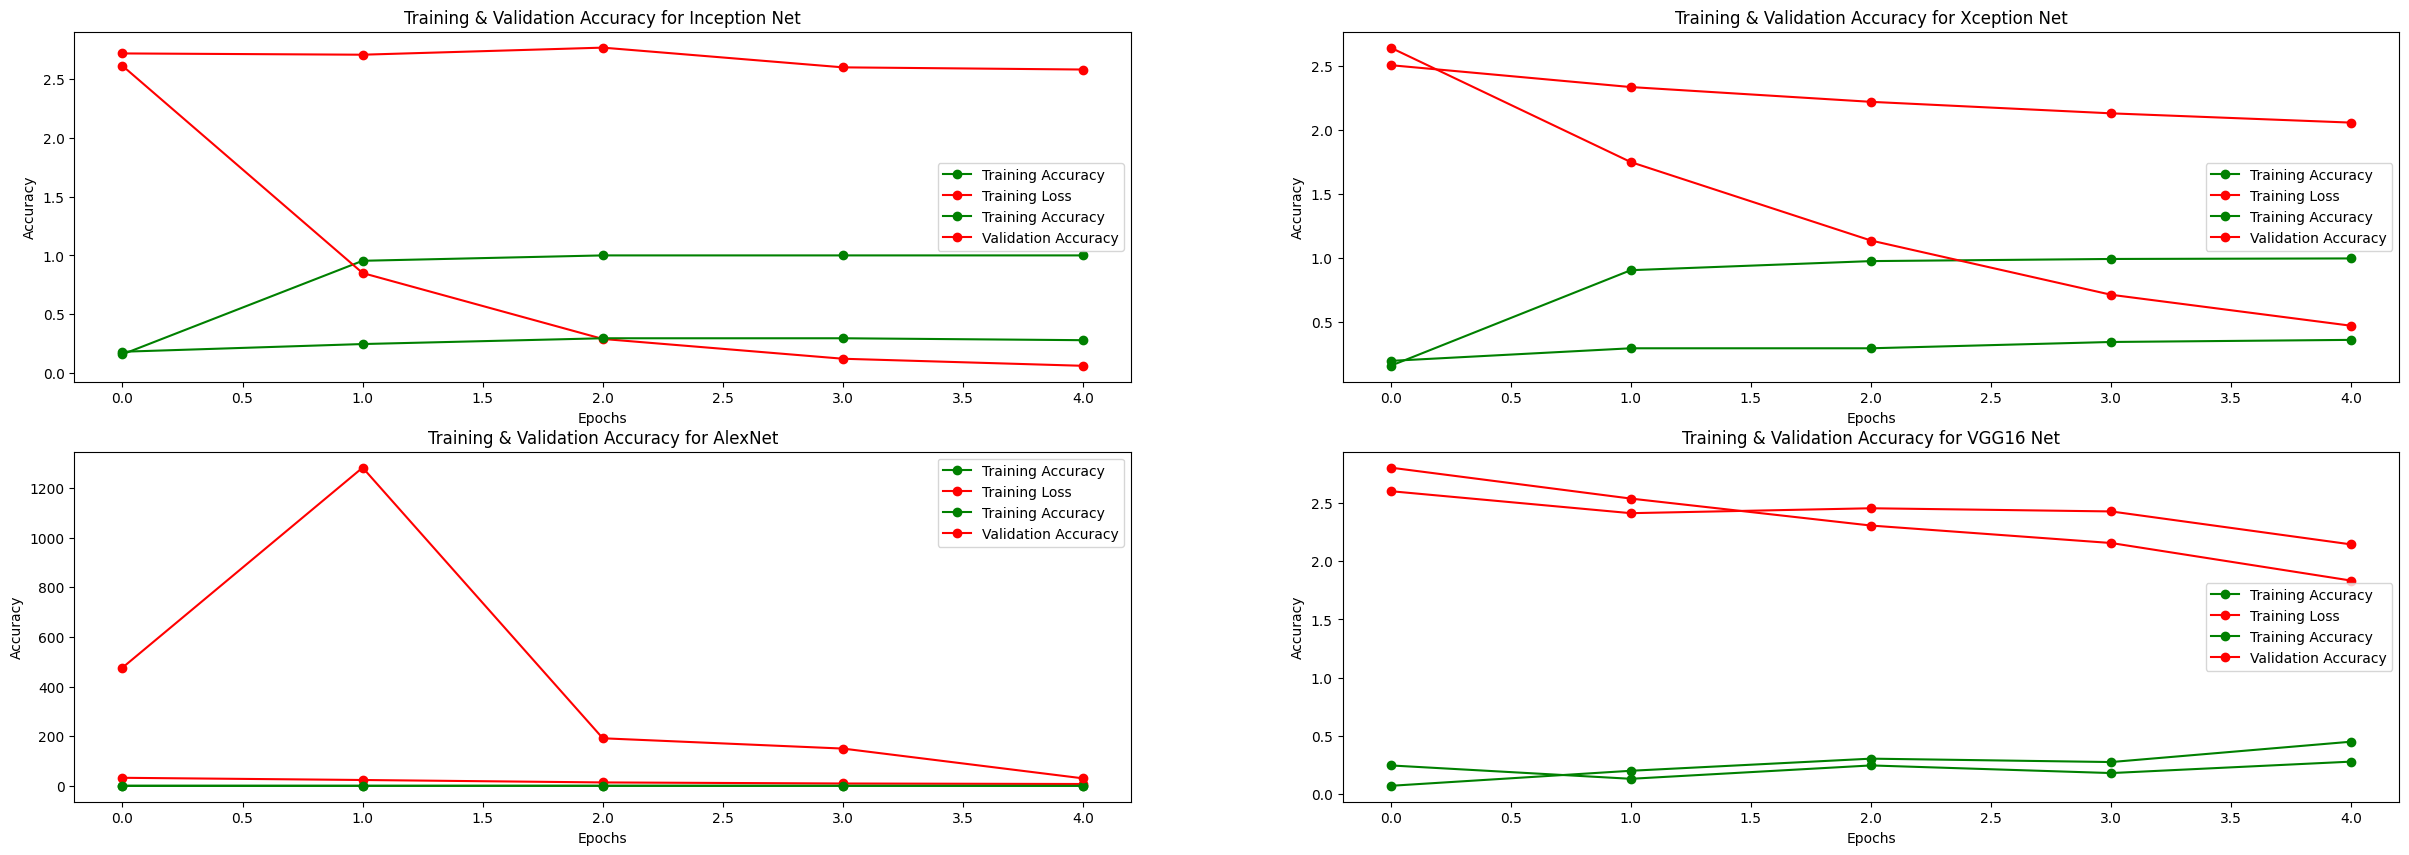

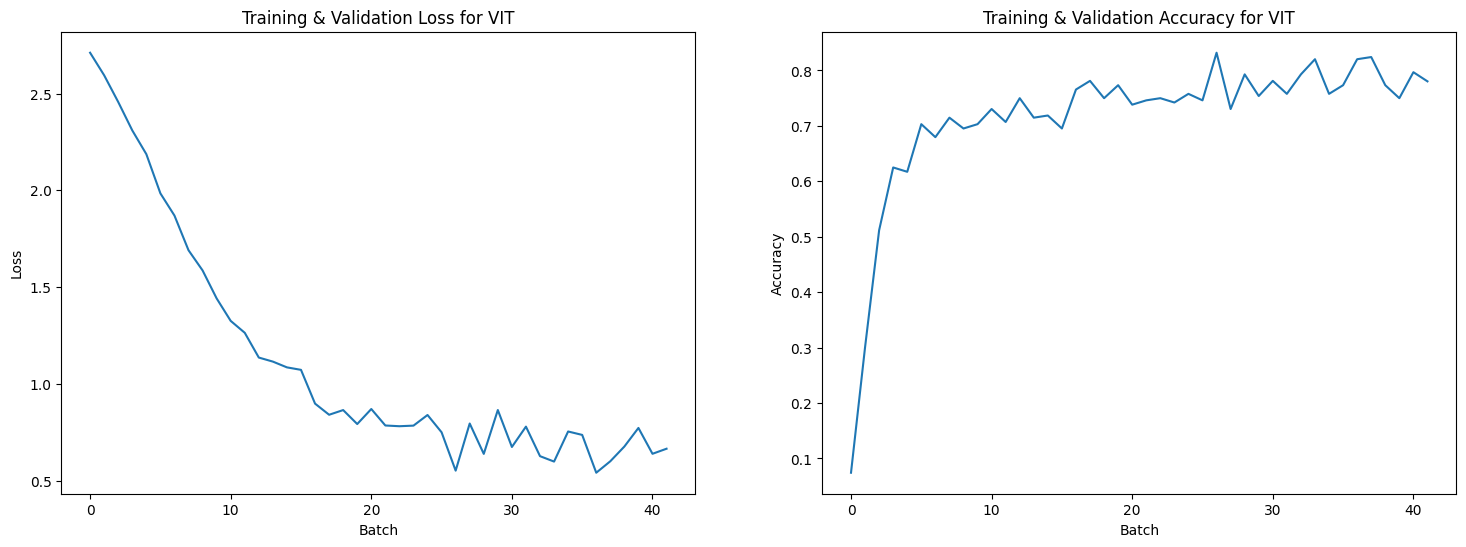

In [52]:
plt.figure(figsize = (30,10))

plt.subplot(2,2,1)
i_train_acc = inception.history['accuracy']
i_val_acc = inception.history['val_accuracy']
i_train_loss = inception.history['loss']
i_val_loss = inception.history['val_loss']
i_epoch = [i for i in range(len(i_val_acc))]
plt.plot(i_epoch , i_train_acc , 'go-' , label = 'Training Accuracy')
plt.plot(i_epoch, i_train_loss , 'ro-' , label = 'Training Loss')
plt.plot(i_epoch , i_val_acc , 'go-' , label = 'Training Accuracy')
plt.plot(i_epoch, i_val_loss , 'ro-' , label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy for Inception Net')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,2)
i_train_acc = xception.history['accuracy']
i_val_acc = xception.history['val_accuracy']
i_train_loss = xception.history['loss']
i_val_loss = xception.history['val_loss']
i_epoch = [i for i in range(len(i_val_acc))]
plt.plot(i_epoch , i_train_acc , 'go-' , label = 'Training Accuracy')
plt.plot(i_epoch, i_train_loss , 'ro-' , label = 'Training Loss')
plt.plot(i_epoch , i_val_acc , 'go-' , label = 'Training Accuracy')
plt.plot(i_epoch, i_val_loss , 'ro-' , label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy for Xception Net')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
i_train_acc = alex.history['accuracy']
i_val_acc = alex.history['val_accuracy']
i_train_loss = alex.history['loss']
i_val_loss = alex.history['val_loss']
i_epoch = [i for i in range(len(i_val_acc))]
plt.plot(i_epoch , i_train_acc , 'go-' , label = 'Training Accuracy')
plt.plot(i_epoch, i_train_loss , 'ro-' , label = 'Training Loss')
plt.plot(i_epoch , i_val_acc , 'go-' , label = 'Training Accuracy')
plt.plot(i_epoch, i_val_loss , 'ro-' , label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy for AlexNet')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")


plt.subplot(2,2,4)
i_train_acc = vgg.history['accuracy']
i_val_acc = vgg.history['val_accuracy']
i_train_loss = vgg.history['loss']
i_val_loss = vgg.history['val_loss']
i_epoch = [i for i in range(len(i_val_acc))]
plt.plot(i_epoch , i_train_acc , 'go-' , label = 'Training Accuracy')
plt.plot(i_epoch, i_train_loss , 'ro-' , label = 'Training Loss')
plt.plot(i_epoch , i_val_acc , 'go-' , label = 'Training Accuracy')
plt.plot(i_epoch, i_val_loss , 'ro-' , label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy for VGG16 Net')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Plot the loss and accuracy
plt.figure(figsize=(18,6))

# Loss
plt.subplot(1, 2, 1)
plt.title("Loss for batch")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title('Training & Validation Loss for VIT')
plt.plot(batch_loss_history)

# Accuracy
plt.subplot(1, 2, 2)
plt.title("Accuracy for batch")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.title('Training & Validation Accuracy for VIT')
plt.plot(batch_accuracy_history)
plt.show()